# Towards Evaluating Creativity in Language

This notebook is a prototype for evaluating creativity in language. It is based on the paper [Towards Evaluating Creativity in Language](https://arxiv.org/abs/1904.09751) by [Rudinger et al.](https://arxiv.org/abs/1904.09751) (2019).
^ bruh copilot at it again

In [157]:
# Imports...
from nltk.tag.mapping import map_tag
import torch
from nltk.corpus import gutenberg
from nltk.text import Text
from nltk.corpus import brown
from nltk.tag.mapping import map_tag
import nltk

from collections import Counter
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# handy features for downloading the datasets

# nltk.download()

# tags = set(tag for _, tag in postagged_words)
tags = {'$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT',
        'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``'}
tag_to_embed = {tag: i for i, tag in enumerate(tags)}
embed_to_tag = {i: tag for i, tag in enumerate(tags)}


# Punctuation
tag_map = dict.fromkeys(['$', "''", '(', ')', ',', '.', ':', '``'], '.')
# Nouns
tag_map.update(dict.fromkeys(['NN', 'NNP', 'NNPS', 'NNS'], 'N'))
# Verbs
tag_map.update(dict.fromkeys(['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'], 'V'))
# Adjectives
tag_map.update(dict.fromkeys(['JJ', 'JJR', 'JJS'], 'J'))
# Adverbs
tag_map.update(dict.fromkeys(['RB', 'RBR', 'RBS'], 'R'))
# Prepositions
tag_map.update(dict.fromkeys(['IN'], 'Prep'))
# Determiners
tag_map.update(dict.fromkeys(['DT', 'PDT', 'WDT'], 'D'))
# Pronouns
tag_map.update(dict.fromkeys(['PRP', 'PRP$', 'WP', 'WP$'], 'P'))
# Conjunctions
tag_map.update(dict.fromkeys(['CC', 'TO'], 'C'))
# Auxiliary
tag_map.update(dict.fromkeys(['MD'], 'A'))
# Miscellaneous 
tag_map.update(dict.fromkeys(['EX', 'FW', 'RP', 'UH', 'CD','POS', 'WRB'], 'M'))
simple_tags = set(tag_map.values())
tag_to_embed_2 = {tag: i for i, tag in enumerate(simple_tags)}
embed_to_tag_2 = {i: tag for i, tag in enumerate(simple_tags)}
# Translate simple tags to human-readable
tag_to_human = {'A': 'Auxiliary', 'C': 'Conjunction', 'D': 'Determiner', 'J': 'Adjective', 'M': 'Miscellaneous', 'N': 'Noun', 'P': 'Pronoun', 'Prep': 'Preposition', 'R': 'Adverb', 'V': 'Verb', '.': 'Punctuation'}


## Load datasets
Note that the following snippet will download some resources and cache them in the `data` directory.

In [8]:
# import requests
# import pathlib
# from datasets.load import load_dataset

# # Check if the file exists, otherwise download it

# cloze_train_path = pathlib.Path("./data/cloze_test_2018_train.csv")
# if not cloze_train_path.exists():
#     cloze_train_path.write_bytes(requests.get("https://goo.gl/0OYkPK").content)

# cloze_val_path = pathlib.Path("./data/cloze_test_2018_val.csv")
# if not cloze_val_path.exists():
#     cloze_val_path.write_bytes(requests.get("https://goo.gl/XWjas1").content)

# cloze_test_path = pathlib.Path("./data/cloze_test_2018_test.csv")
# if not cloze_test_path.exists():
#     cloze_test_path.write_bytes(requests.get("https://goo.gl/BcTtB4").content)

# tiny_shakespeare_path = pathlib.Path("./data/tiny_shakespeare.txt")
# if not tiny_shakespeare_path.exists():
#     tiny_shakespeare_path.write_bytes(requests.get("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt").content)

# val_ds = pd.read_csv(cloze_val_path)
# # val_ds = load_dataset('csv', "val", data_files=cloze_val_path.__str__())

# # tiny_shakespeare = load_dataset('tiny_shakespeare')
# with open(tiny_shakespeare_path, 'r') as f:
#     tiny_shakespeare = f.read()


# # Load the datasets later
# # train_ds = load_dataset('csv', "train", data_files=cloze_train_path.__str__())
# # test_ds = load_dataset('csv', "test", data_files=cloze_test_path.__str__())


In [3]:
# Yikes, the chaining to access this
# tiny_shakespeare["train"][0]["text"].__len__()

# nltk.pos_tag(nltk.word_tokenize("The quick brown fox jumps over the lazy dog."))
# nltk.corpus.gutenberg.words("austen-emma.txt")[:300]


### Potential creativity measures
#### Usage of less common vocabulary uncommon words
**Example:**
- "The quick brown fox jumps over the lazy dog."
- "The swift hazel-furred fox leaps over the idle dog."

**Idea:**

Adapt resources such as WordNet for finding semantically similar words and compare them to their most used synonym. Notion: The more uncommon the word, the more creative the sentence.
Potential problems: words could be too far off from their actual meaning in the context. For example, here "leaps" is a synonym for "jumps", but using the word "vaults" or "springs" might not fit the context.


#### Comparing alternatives for bi(+)grams 
(Generally, we want to narrow down on adjectives and noun phrases, but this could be expanded to verb phrases for example.)  
**Two variants:**
1. Compare how much the original word deviates in comparison to contextual synonyms/alternatives. That is, compare $ P(w_{original}|context) $ with $ \{P(w| context) | w \text{ in the set of alternative continuations}\} $. **This is somewhat akin to the perplexity measure, I believe?**
   - *Example:* (The following has been generated by Copilot) Given the sentence "The quick brown fox jumps over the lazy dog.", the context word is "fox" and the alternative contexts are "dog" and "cat". The probability of "jumps" given "fox" is compared to the probabilities of "jumps" given "dog" and "cat". 
   - **Alternatively**, to simplify the formulas, we can compare the deviation of probability $ P(w_{original}|context) $ with respect to the likeliest/largest/maximum element in the set of probability distribution described above, i.e. $\max (\{ P(w|context) | w \in S_{Alternatives}\})$ 


2. Compare the deviation of probability $ P(word|modifier) $ with respect to the set $ \{P(word| alt) | alt \text{ in the set of alternative modifiers}\}$
   - *Example:* Given the sentence "The quick *brown* **fox** jumps over the lazy dog.", the $word$ is **"fox"** and the $modifier$ is *"brown"*. Then, the alternative modifiers can be "black", "reddish", or even "blue".
   - This can be summarised by doing evaluation on the noun phrase level. I'd personally prefer focusing on the prepositional modifier words.

In [2]:
from typing import Generator


class CreativityBenchmark:
    def __init__(self, raw_text: str):
        self.raw_text = raw_text
        self.words = nltk.word_tokenize(raw_text, preserve_line=True)
        self.sents = nltk.sent_tokenize(self.raw_text)

        # Initialize a list to hold the POS tag counts for each sentence
        self.pos_tag_counts = []

    def ngrams(self, n, **kwargs):
        return nltk.ngrams(self.raw_text, n, kwargs)

    def sent_postag_counts(self) -> list[nltk.FreqDist]:
        """Returns sentence-level counts of POS tags for each sentence in the text. """
        if self.pos_tag_counts != []:
            return self.pos_tag_counts
        else:
            # Collect POS data for each sentence
            for sentence in self.sents:
                # Initialize a counter for the POS tags on the sentence level
                lib = nltk.FreqDist()

                word_tokens = nltk.word_tokenize(sentence)
                pos_tagged_tokens = nltk.pos_tag(word_tokens)
                for _,token in pos_tagged_tokens:
                    lib[token] += 1

                self.pos_tag_counts.append(lib)

            return self.pos_tag_counts

    def book_postag_counts(self) -> nltk.FreqDist:
        """Get a counter object for the Parts of Speech in the whole book."""
        # Note this approach does not give completely equal results to get_sent_postag_counts despite being a bit faster
        # freq_dist = nltk.FreqDist(self.words)
        # tagged = nltk.pos_tag(freq_dist.keys())

        # count = nltk.FreqDist()
        # for (_, val), (_, tag) in zip(freq_dist.items(), tagged):
        #     count[tag] += val
        
        # Opt to use this instead for consistency.
        book_total_postags = nltk.FreqDist()
        for l in self.sent_postag_counts():
            book_total_postags += l
        return book_total_postags

    def num_tokens_per_sentence(self) -> Generator[int, None, None]:
        return (len(nltk.word_tokenize(sentence)) for sentence in self.sents)
    
    def total_tokens_per_sentence(self) -> int:
        return sum(self.num_tokens_per_sentence())

    def avg_tokens_per_sentence(self) -> float:
        return sum(self.num_tokens_per_sentence())/len(self.sents)
    
bench = CreativityBenchmark(gutenberg.raw("austen-emma.txt"))

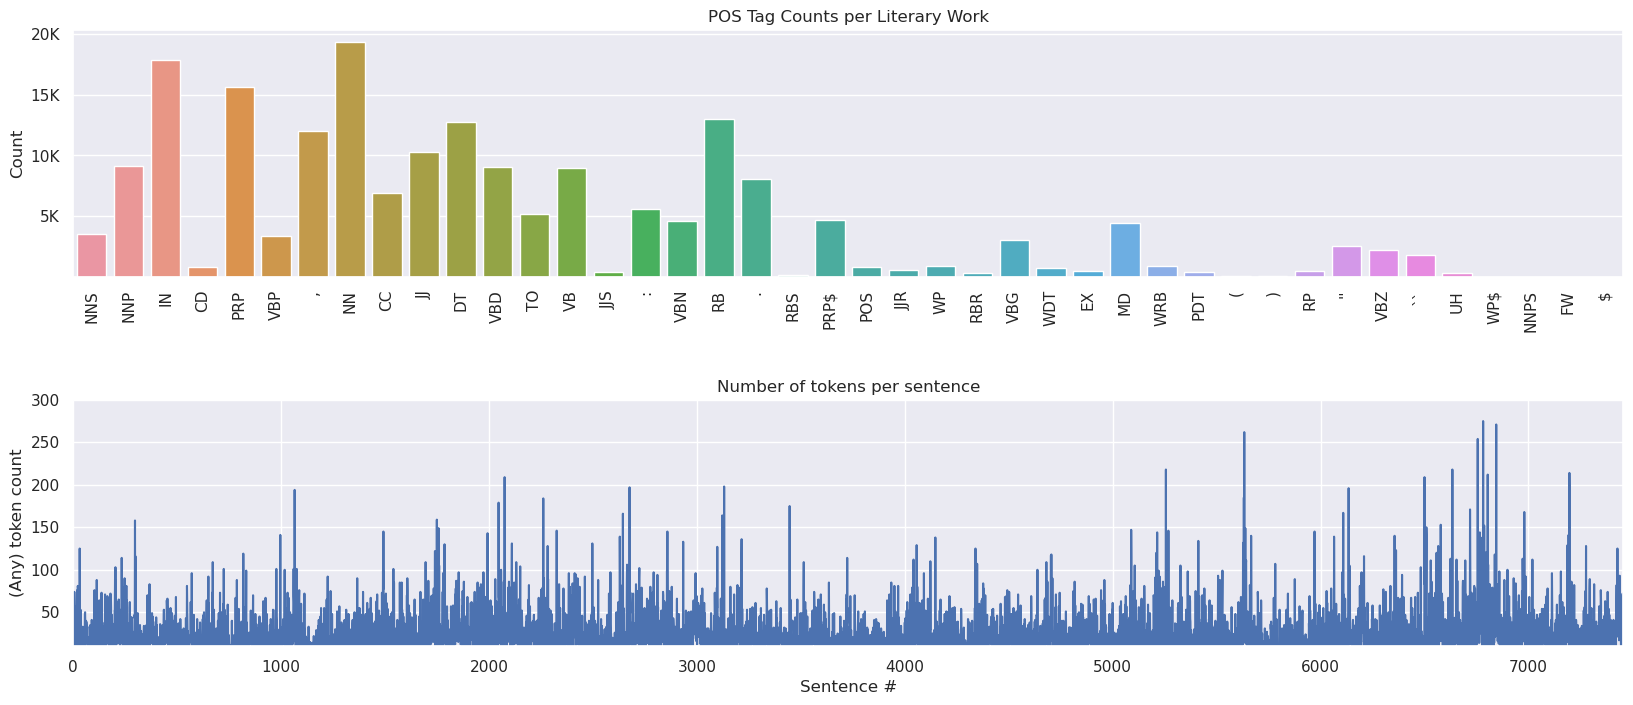

In [4]:
# Potentially consider color schemes for nounds, adjectives, etc., not just a random one
book_total_postags = bench.book_postag_counts()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))
sns.barplot(x=list(book_total_postags.keys()), y=list(
    book_total_postags.values()), label="Emma", ax=ax1)
ax1.set_title("POS Tag Counts per Literary Work")
ax1.set_ylabel("Count")
ax1.set_ylim(bottom=30)
# Set counts to appear with the K suffix
ax1.yaxis.set_major_formatter(plt.FuncFormatter(
    lambda x, loc: "{:,}K".format(int(x/1000))))
ax1.tick_params(axis='x', labelrotation=90)

num_tokens_per_sentence = list(bench.num_tokens_per_sentence())
ax2.set(title="Number of tokens per sentence", xlabel="Sentence #",
        ylabel="(Any) token count", ylim=(10, 300), xlim=(0, len(num_tokens_per_sentence)))
ax2.plot(list(num_tokens_per_sentence))

fig.subplots_adjust(hspace=0.5)

# Average number of tokens per sentence
avg_num_tokens = bench.avg_tokens_per_sentence()


Possible algorithm for measuring number of tokens per sentence:
1. Split the text into sentences using the sentence tokenizer.
2. For each sentence, split it into tokens using the word tokenizer.

Additionally, plot the distribution of the number of tokens per sentence.
Additionally, plot the distribution of different PoS tags per sentence.
Do this for a few genres and compare them. PLOT PLOTS PLOTS


In [6]:
sent_pos_tag_counts = bench.sent_postag_counts()

df = pd.DataFrame(sent_pos_tag_counts)
df.fillna(0, inplace=True)


# merge the columns of df with sum
# Nouns
df['NN'] = df['NN'] + df['NNS'] + df['NNP'] + df['NNPS']
# Adjectives
df['JJ'] = df['JJ'] + df['JJR'] + df['JJS']
# Adverbs
df['RB'] = df['RB'] + df['RBR'] + df['RBS']
# Verbs
df['VB'] = df['VB'] + df['VBD'] + df['VBG'] + df['VBN'] + df['VBP'] + df['VBZ']
# Pronouns (includes wh-pronouns)
df['PRP'] = df['PRP'] + df['PRP$'] + df['WP'] + df['WP$']
# Determiners
df['DT'] = df['DT'] + df['WDT'] + df['PDT']
# Foreign words [FW]
# Punctuation
df['.'] = df['.'] + df[','] + df[':'] + df['``'] + \
    df["''"] + df['('] + df[')'] + df['$']
# Miscellaneous
df['EX'] = df['EX'] + df['CC'] + df['CD'] + df['MD'] + df['UH']

# Keep Nouns, Adjectives, Adverbs, Verbs, Pronouns, Determiners, Punctuation, Foreign words, and Miscellaneous
df = pd.DataFrame(df, columns=['NN', 'JJ', 'RB',
                  'VB', 'PRP', 'DT', '.', 'FW', 'EX'])
df = df.div(df.sum(axis=1), axis=0)


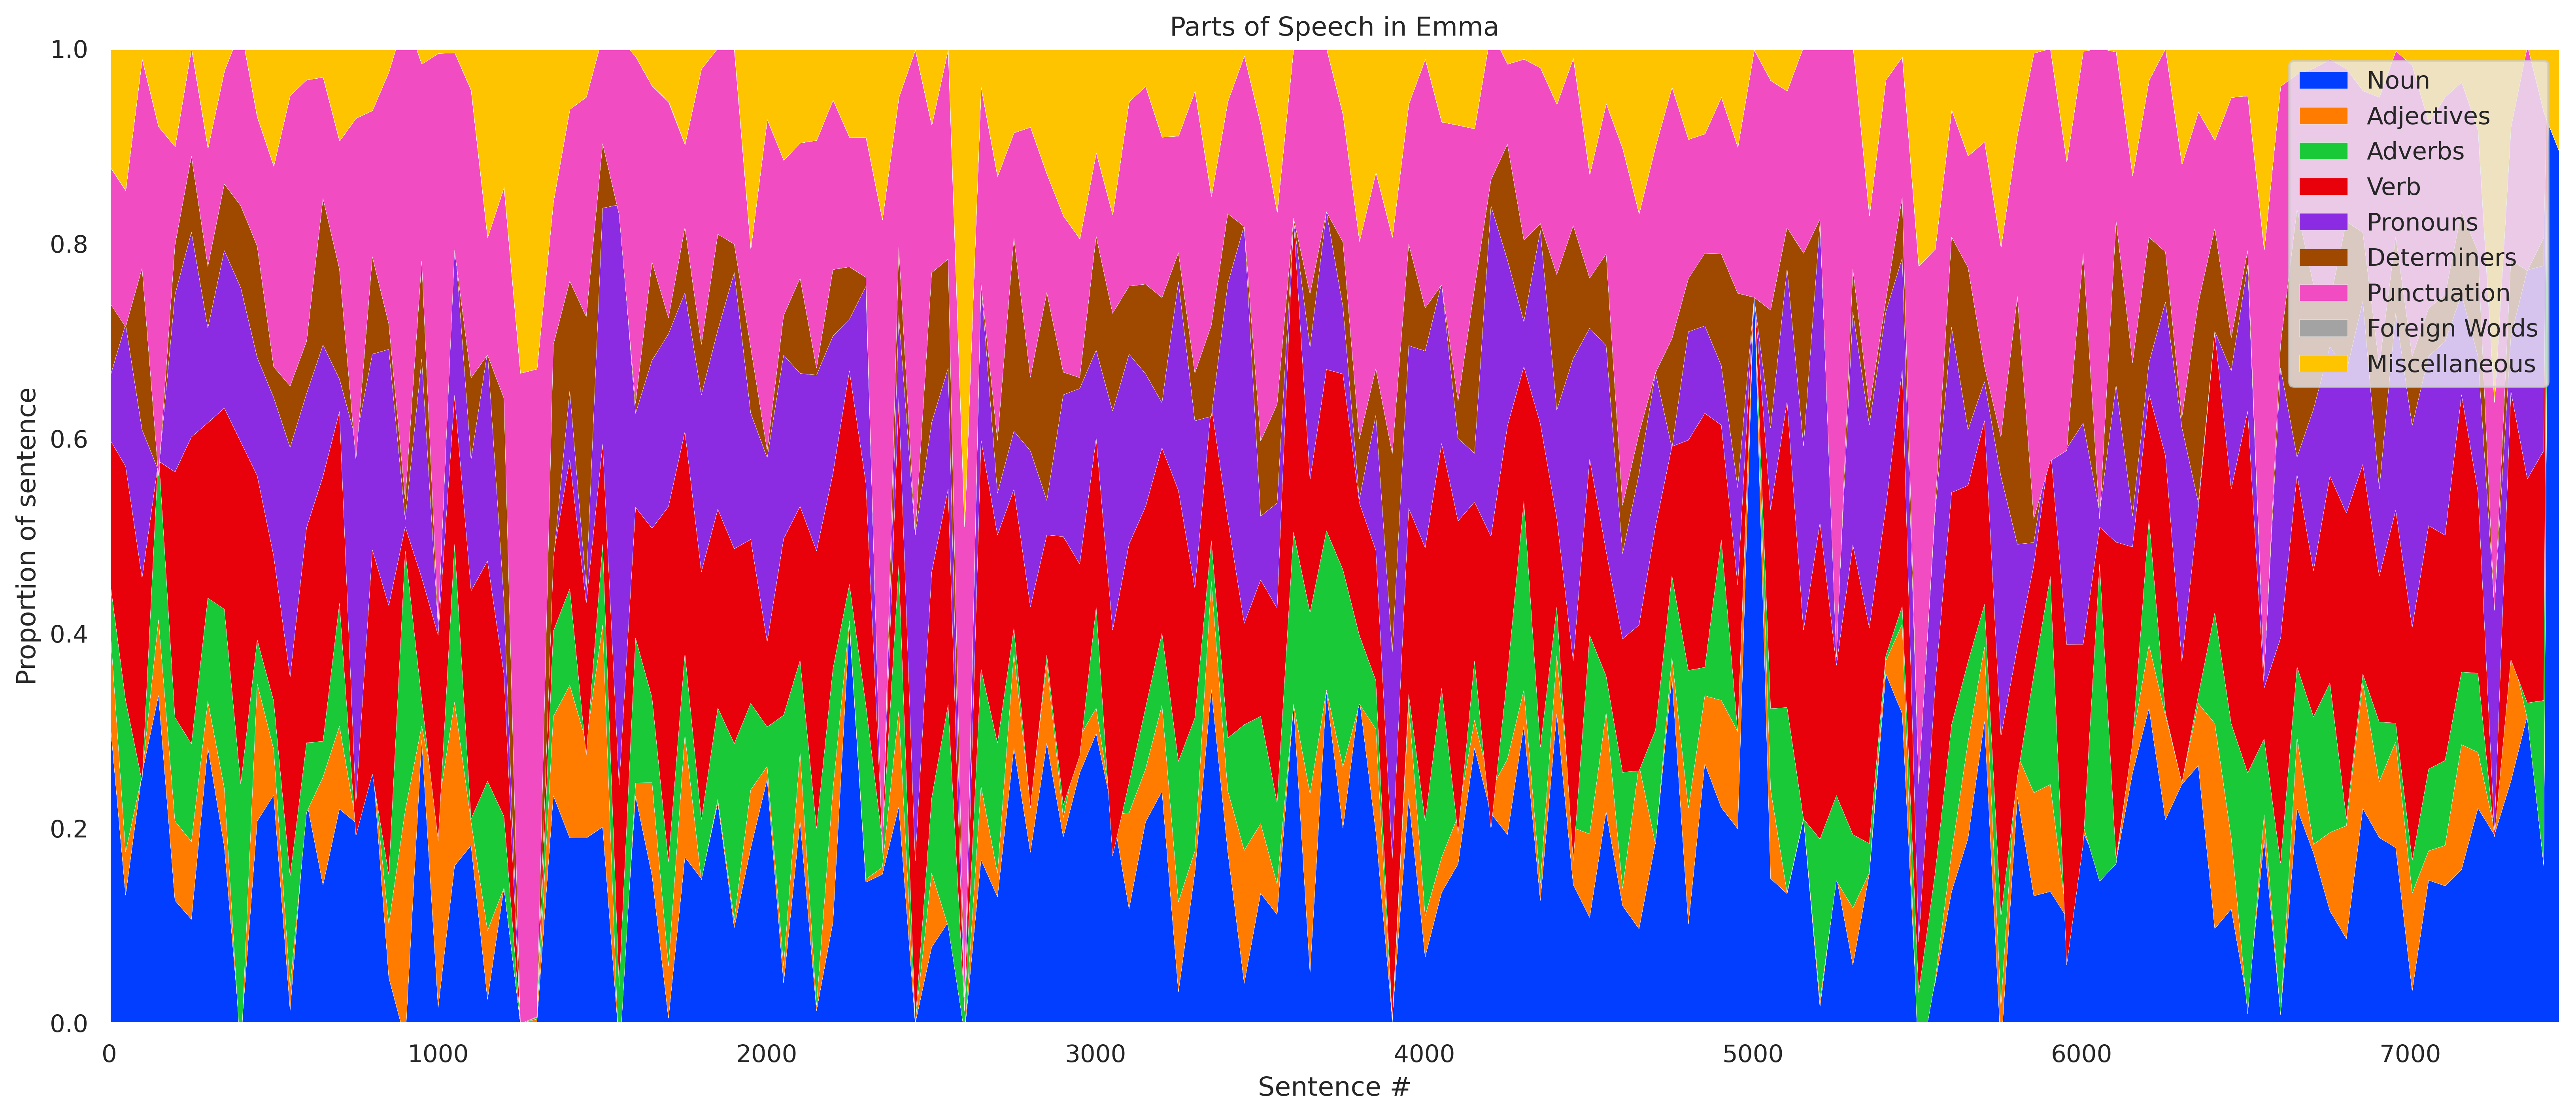

In [19]:
# Smooth out the curve
from scipy.interpolate import make_interp_spline

fig, ax = plt.subplots(figsize=(20, 8), dpi=400)
graphs = []
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, df.shape[0], 150)

for label in df.columns:
    spl = make_interp_spline(list(df.index), df[label], k=3)  # BSpline object
    power_smooth = spl(xnew)
    graphs.append(power_smooth)

ax.stackplot(xnew, *graphs, labels=['Noun', 'Adjectives', 'Adverbs',
                                    'Verb', 'Pronouns', 'Determiners', 'Punctuation', 'Foreign Words', 'Miscellaneous'], linewidth=0.1, colors=sns.color_palette("bright", n_colors=df.shape[1], as_cmap=True))
ax.set(xlim=(0, len(bench.sents)), ylim=(0, 1), title='Parts of Speech in Emma',
       xlabel='Sentence #', ylabel='Proportion of sentence')
ax.legend();


In [158]:
postagged_words = nltk.pos_tag(bench.words)
postagged_words = [(word, map_tag('en-ptb', 'universal', tag))
                          for word, tag in postagged_words]


# Show the most common collocations of POS tags

tag_to_embed = {tag: i for i, tag in enumerate(nltk.tag.mapping._UNIVERSAL_TAGS)}
embed_to_tag = {i: tag for i, tag in enumerate(nltk.tag.mapping._UNIVERSAL_TAGS)}

counter = torch.zeros((len(nltk.tag.mapping._UNIVERSAL_TAGS), len(
    nltk.tag.mapping._UNIVERSAL_TAGS)), dtype=torch.int32)
for pair_1, pair_2 in zip(postagged_words, postagged_words[1:]):
    counter[tag_to_embed[pair_1[1]], tag_to_embed[pair_2[1]]] += 1
# print(counter)

tensor([[ 6762,  2408,  5197,  1838,  6135,  3859,   289,  3836,   148,  2277,
             6,  3138],
        [ 4137,  4832,  2046,   265,  1119,  6388,  1355,   820,    25,  1993,
            14, 10362],
        [11246,  3105,   335,  1073,   999,   789,   115,   492,    38,   461,
             3,  1713],
        [  250,  5766,   482,   531,   219,  1177,   283,   303,    45,   649,
            11,  1765],
        [ 4047,   481,   803,  2594,  1621,  1321,   111,   531,    62,   385,
             0,  1796],
        [  949,  4297,  5044,  1204,   367,   442,    28,  4817,   166,   209,
             3,   403],
        [ 1269,  1348,  1289,   376,   847,   737,     3,   719,    77,    66,
             2,   203],
        [ 1271,  7751,   348,  2930,   637,   223,     7,   518,   121,    53,
             3,   294],
        [   92,   359,    15,    67,    18,    94,    28,     9,     5,    17,
             0,    60],
        [ 3628,  1090,   634,    97,    61,   136,    21,   544,    14,  

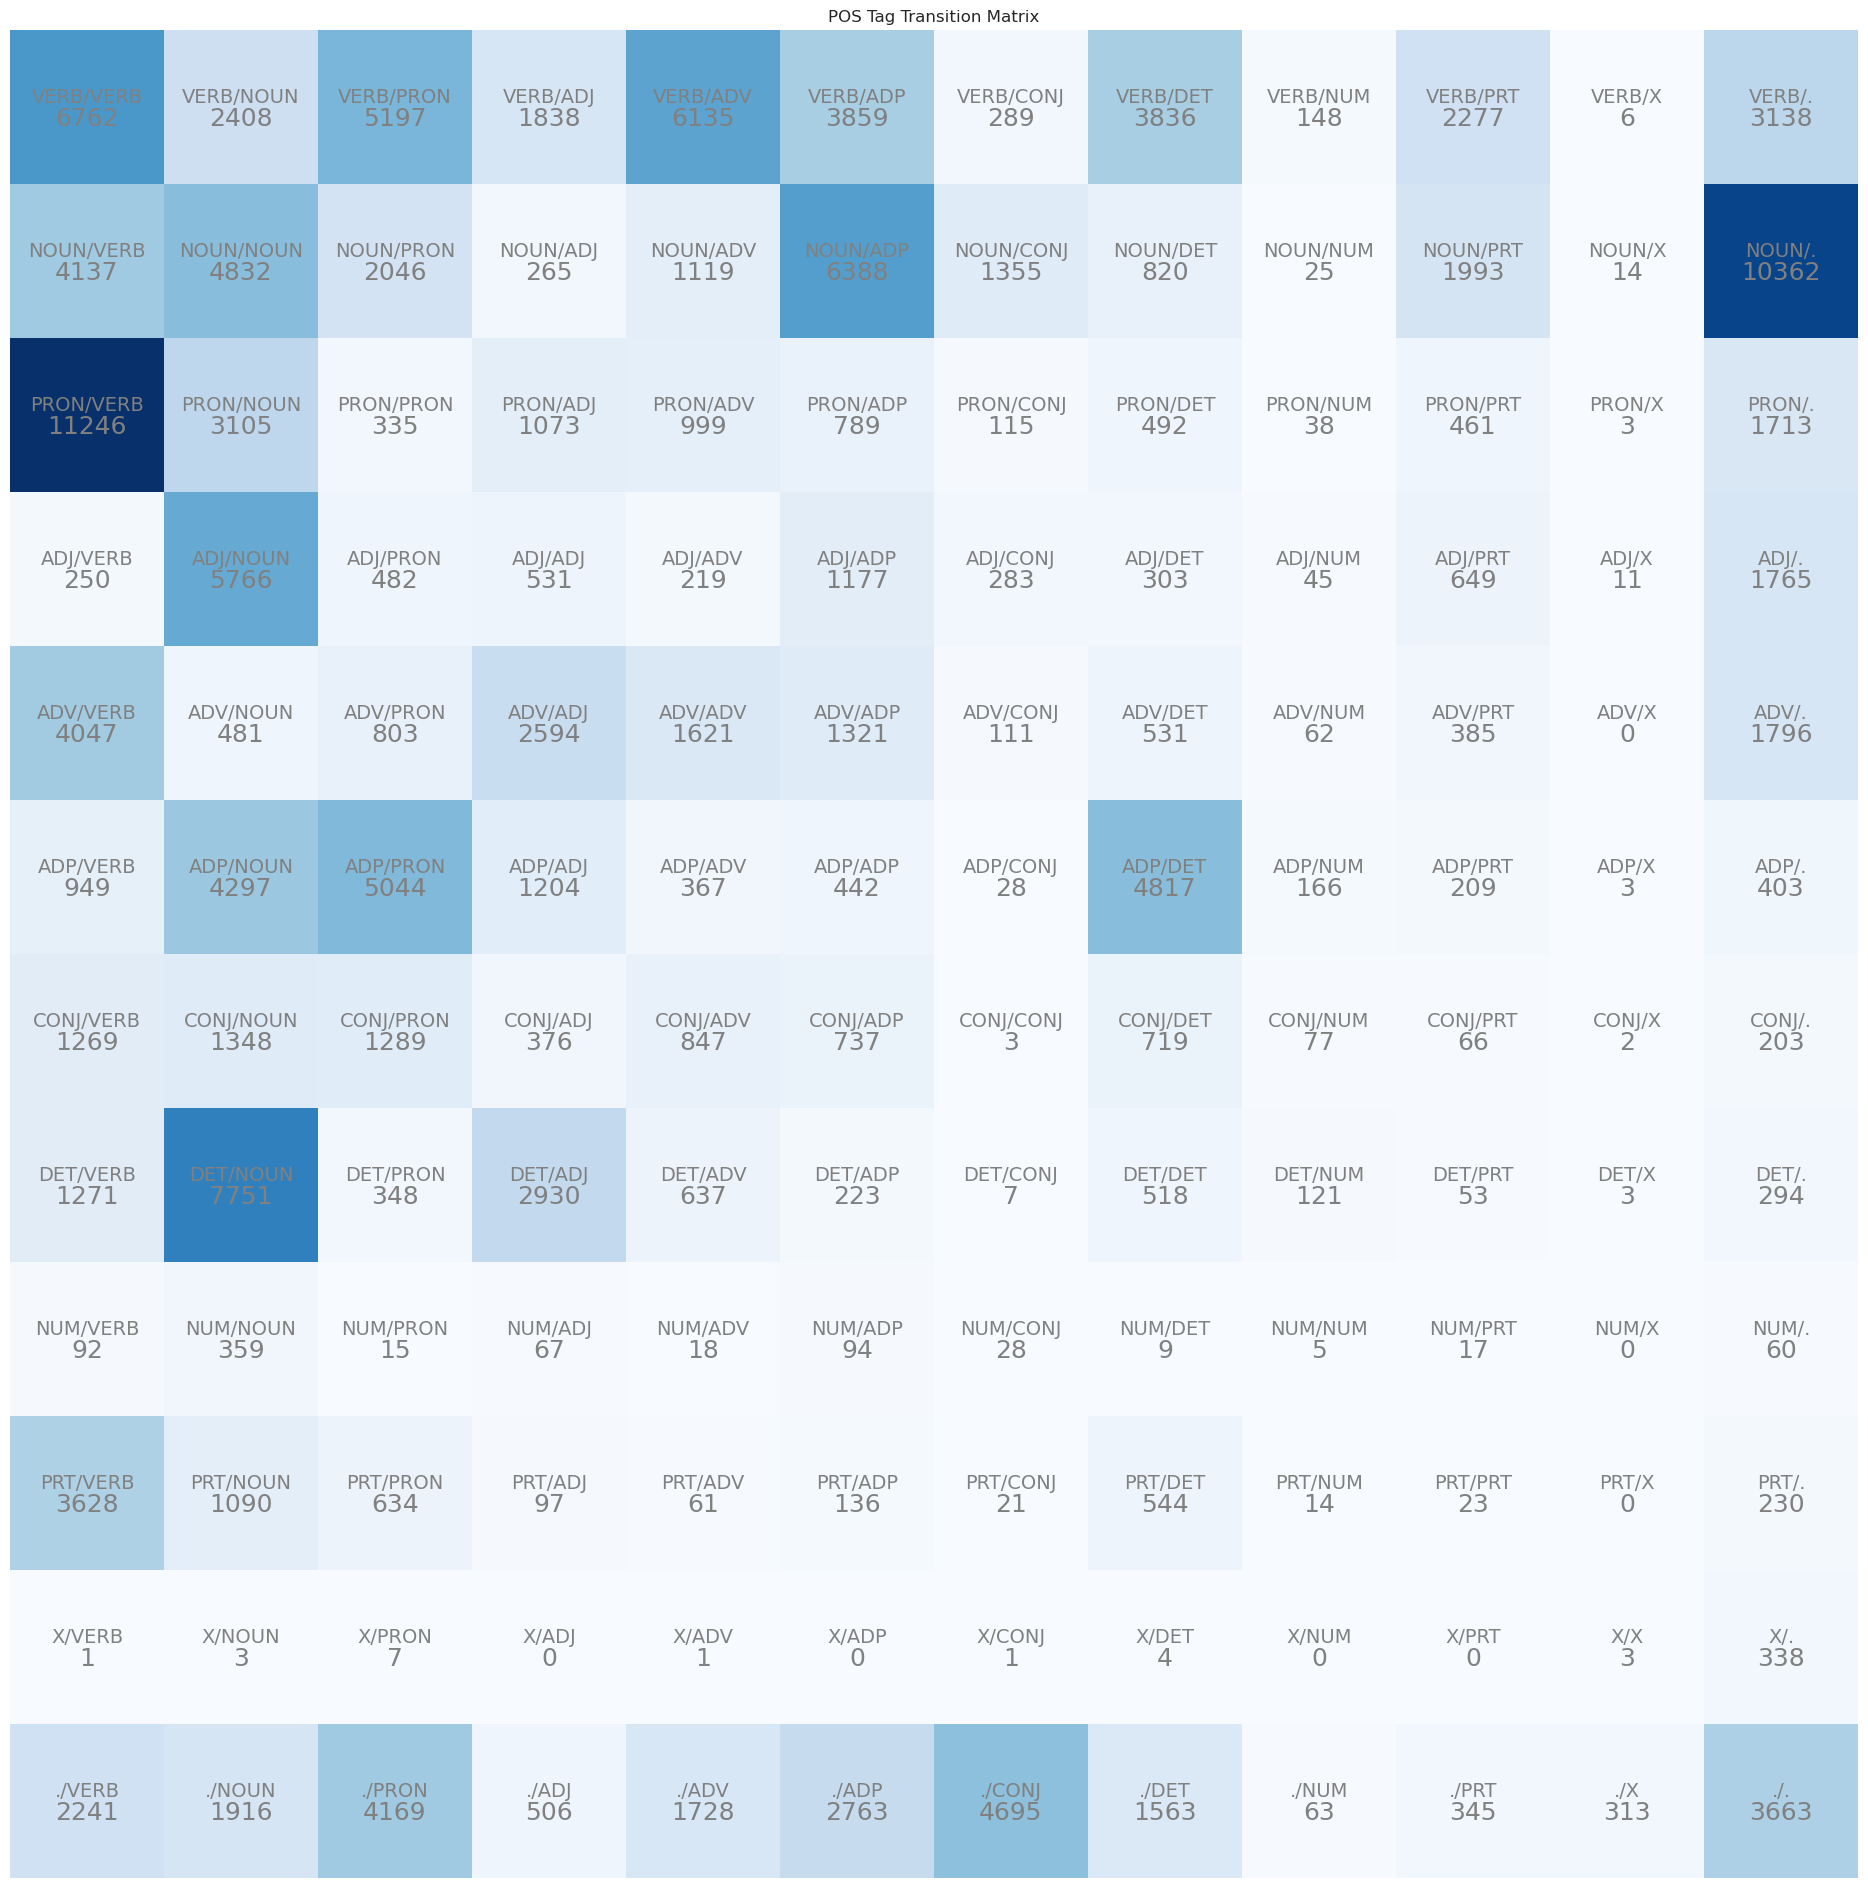

In [161]:
plt.figure(figsize=(24, 24))
plt.imshow(counter, cmap="Blues")
for i in range(counter.shape[0]):
    for j in range(counter.shape[1]):
        plt.text(j, i, embed_to_tag[i]+'/'+embed_to_tag[j], ha="center", va="bottom", color="gray", fontdict={'size': 14})
        plt.text(j, i, counter[i, j].item(), ha="center", va="top", color="gray", fontdict={'size': 18})

plt.title("POS Tag Transition Matrix")
plt.axis('off');

In [151]:
# %%time
words = brown.tagged_words(categories='mystery', tagset='universal')
# print(brown.readme())
# nltk.download()
list(i for idx, i in enumerate(words.iterate_from(0)))[:100]

[('There', 'PRT'),
 ('were', 'VERB'),
 ('thirty-eight', 'NUM'),
 ('patients', 'NOUN'),
 ('on', 'ADP'),
 ('the', 'DET'),
 ('bus', 'NOUN'),
 ('the', 'DET'),
 ('morning', 'NOUN'),
 ('I', 'PRON'),
 ('left', 'VERB'),
 ('for', 'ADP'),
 ('Hanover', 'NOUN'),
 (',', '.'),
 ('most', 'ADJ'),
 ('of', 'ADP'),
 ('them', 'PRON'),
 ('disturbed', 'VERB'),
 ('and', 'CONJ'),
 ('hallucinating', 'VERB'),
 ('.', '.'),
 ('An', 'DET'),
 ('interne', 'NOUN'),
 (',', '.'),
 ('a', 'DET'),
 ('nurse', 'NOUN'),
 ('and', 'CONJ'),
 ('two', 'NUM'),
 ('attendants', 'NOUN'),
 ('were', 'VERB'),
 ('in', 'ADP'),
 ('charge', 'NOUN'),
 ('of', 'ADP'),
 ('us', 'PRON'),
 ('.', '.'),
 ('I', 'PRON'),
 ('felt', 'VERB'),
 ('lonely', 'ADJ'),
 ('and', 'CONJ'),
 ('depressed', 'VERB'),
 ('as', 'ADP'),
 ('I', 'PRON'),
 ('stared', 'VERB'),
 ('out', 'ADP'),
 ('the', 'DET'),
 ('bus', 'NOUN'),
 ('window', 'NOUN'),
 ('at', 'ADP'),
 ("Chicago's", 'NOUN'),
 ('grim', 'ADJ'),
 (',', '.'),
 ('dirty', 'ADJ'),
 ('West', 'ADJ'),
 ('Side', 'NOUN'),
 (

In [165]:
# Show the most common collocations of POS tags
brown_mystery_words = brown.tagged_words(categories='news', tagset='universal')

counter = torch.zeros((len(nltk.tag.mapping._UNIVERSAL_TAGS), len(
    nltk.tag.mapping._UNIVERSAL_TAGS)), dtype=torch.int32)
for pair_1, pair_2 in zip(brown_mystery_words, brown_mystery_words[1:]):
    counter[tag_to_embed[pair_1[1]], tag_to_embed[pair_2[1]]] += 1
# print(counter)


(-0.5, 11.5, 11.5, -0.5)

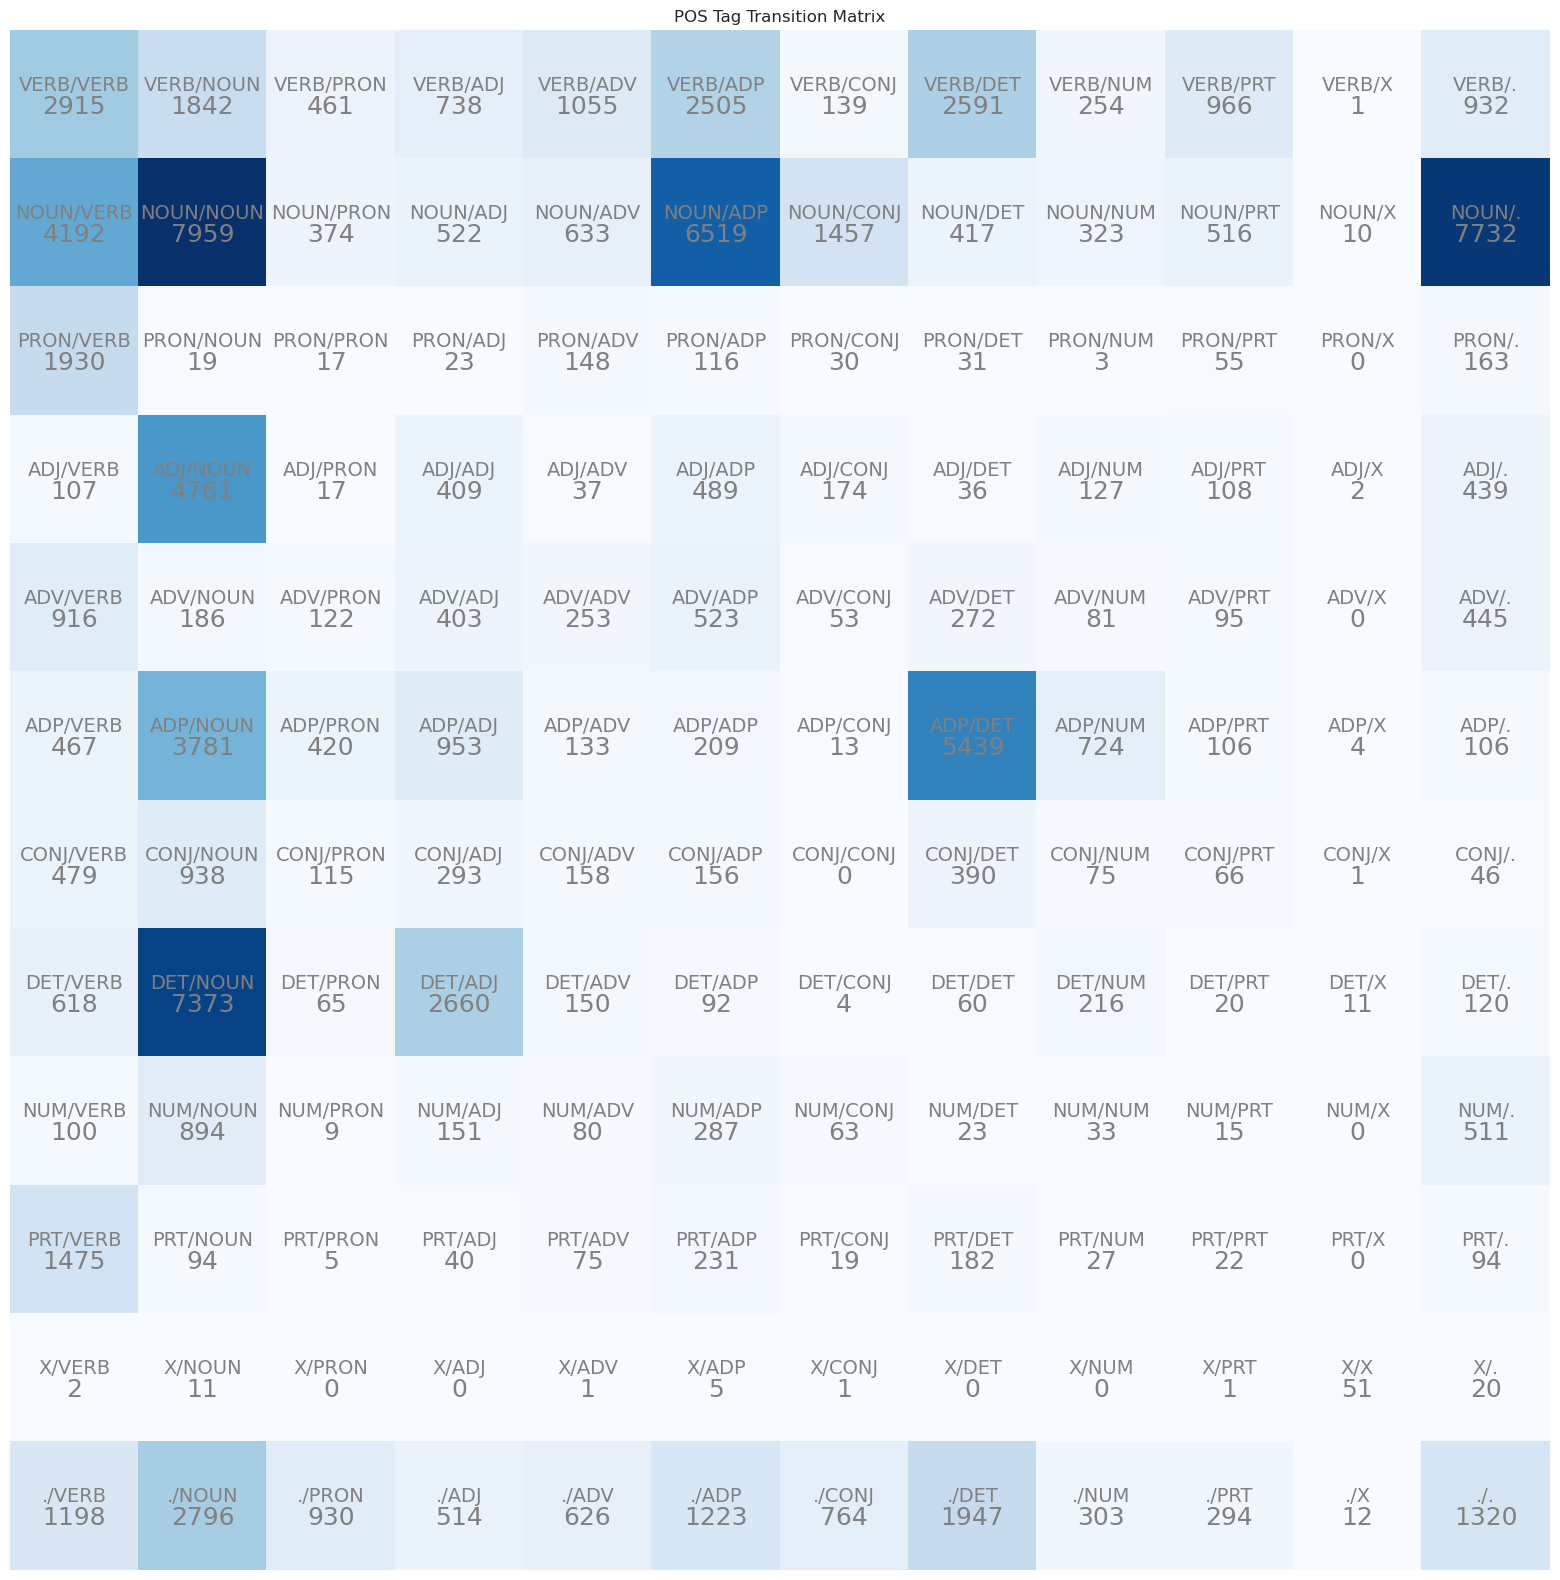

In [166]:
plt.figure(figsize=(20, 20))
plt.imshow(counter, cmap="Blues")
for i in range(counter.shape[0]):
    for j in range(counter.shape[1]):
        plt.text(j, i, embed_to_tag[i]+'/'+embed_to_tag[j], ha="center",
                 va="bottom", color="gray", fontdict={'size': 14})
        plt.text(j, i, counter[i, j].item(), ha="center",
                 va="top", color="gray", fontdict={'size': 18})

plt.title("POS Tag Transition Matrix")
plt.axis('off')


In [167]:
counter.sum()

tensor(100553)